In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path
from glob import glob
import cv2
import torch
from PIL import Image
import tqdm

from inference_utils import sample
from rsl_depth_completion.diffusion.configs import DiffusionConfig
from torchvision import transforms
from torch.utils.data import DataLoader
import torchvision as tv
from unet import Unet
from diffusion_utils import q_sample, extract
from utils import set_seed
from torchvision.utils import save_image
from schedulers import (cosine_beta_schedule,
linear_beta_schedule,
quadratic_beta_schedule,
sigmoid_beta_schedule)
import torch.nn.functional as F
from torch.optim import Adam
import gc

from pathlib import Path
import shutil

%matplotlib inline

/home/master/.conda/envs/ssdc/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/master/.conda/envs/ssdc/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c106detail23torchInternalAssertFailEPKcS2_jS2_RKSs'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


# config

In [2]:
input_channels = 1
timesteps = 200
# timesteps = 30

seed = 100
set_seed(seed)

run_name='test'
results_folder = Path("./results") / run_name
shutil.rmtree(results_folder, ignore_errors=True)
results_folder.mkdir(exist_ok = True)


# DIFFUSION

In [3]:
# define beta schedule
betas = linear_beta_schedule(timesteps=timesteps)

# define alphas 
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)

# calculations for diffusion q(x_t | x_{t-1}) and others
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)

# calculations for posterior q(x_{t-1} | x_t, x_0)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

def extract(a, t, x_shape):
    batch_size = t.shape[0]
    out = a.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

In [4]:

diffusion_config = DiffusionConfig(
    betas=betas,
    sqrt_one_minus_alphas_cumprod=sqrt_one_minus_alphas_cumprod,
    sqrt_alphas_cumprod=sqrt_alphas_cumprod,
    sqrt_recip_alphas=sqrt_recip_alphas,
    posterior_variance=posterior_variance,
)

# LOSS

In [5]:
def p_losses(denoise_model, x_start, t, noise=None, loss_type="l1"):
    if noise is None:
        noise = torch.randn_like(x_start)

    x_noisy = q_sample(x_start=x_start, t=t, noise=noise, diffusion_config=diffusion_config)
    predicted_noise = denoise_model(x_noisy, t)

    if loss_type == 'l1':
        loss = F.l1_loss(noise, predicted_noise)
    elif loss_type == 'l2':
        loss = F.mse_loss(noise, predicted_noise)
    elif loss_type == "huber":
        loss = F.smooth_l1_loss(noise, predicted_noise)
    else:
        raise NotImplementedError()

    return loss

# data setup

In [6]:
init_image_size = (352, 1216)
crop_image_size = (352, 1216 // 3)
target_image_size = (152, 200)
input_channels = 1
batch_size = 2



In [7]:
transform = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(crop_image_size),
        transforms.Resize(target_image_size),
        transforms.ToTensor(),
        transforms.Lambda(lambda t: (t * 2) - 1),
    ]
)


def train_transforms(img):
    examples = {}
    examples["pixel_values"] = transform(img.convert("L"))

    return examples


In [8]:
ds=tv.datasets.ImageFolder(root="/media/master/wext/msc_studies/second_semester/research_project/related_work/calibrated-backprojection-network/results/kitti_dc_val/outputs")
sdm_idx = ds.class_to_idx['sparse_depth']
ds.samples = [x for x in ds.samples if x[1] == sdm_idx]
ds.targets = [x for x in ds.targets if x == sdm_idx]
ds.transform = train_transforms
x = ds[0]
x[0]['pixel_values'].shape

torch.Size([1, 152, 200])

# train

In [9]:
from torchvision import transforms
from torch.utils.data import DataLoader
from datasets import load_dataset

# load dataset from the hub
dataset = load_dataset("fashion_mnist")
target_image_size = (28, 28)
channels = 1
batch_size = 4
# define image transformations (e.g. using torchvision)
transform = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Lambda(lambda t: (t * 2) - 1)
])

# define function
def hf_transforms(examples):
   examples["pixel_values"] = [transform(image.convert("L")) for image in examples["image"]]
   del examples["image"]

   return examples

transformed_dataset = dataset.with_transform(hf_transforms).remove_columns("label")

# create dataloader
dataloader = DataLoader(transformed_dataset["train"], batch_size=batch_size, shuffle=True)

Found cached dataset fashion_mnist (/home/master/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/0a671f063342996f19779d38c0ab4abef9c64f757b35af8134b331c294d7ba48)


  0%|          | 0/2 [00:00<?, ?it/s]

In [13]:
# subset = torch.utils.data.Subset(ds, range(0, batch_size))
# subset = ds
# dataloader = DataLoader(subset, batch_size=batch_size, shuffle=True)

In [14]:
gc.collect()
torch.cuda.empty_cache()

time_dim_input = 28
time_dim_hidden = 112
first_hidden_dim = 18
final_conv_hidden_dim = 28
out_dim = 1

lr = 1e-3

model = Unet(
    time_dim_input=time_dim_input,
    time_dim_hidden=time_dim_hidden,
    first_hidden_dim=first_hidden_dim,
    final_conv_hidden_dim=final_conv_hidden_dim,
    hidden_dim_scalers=[1, 2, 4],
    out_dim=out_dim,
    channels=1,
    with_time_emb=True,
)
device = "cuda" if torch.cuda.is_available() else "cpu"
# device = "cpu"

model = model.to(device)
optimizer = Adam(model.parameters(), lr=lr)

AttributeError: 'Unet' object has no attribute 'time_dim'

In [15]:

epochs = 700
save_and_sample_every = 2000

for epoch in tqdm.tqdm(range(epochs), desc="Epoch"):
    for step, batch in enumerate(dataloader):
    # for step, batch in tqdm.tqdm(enumerate(dataloader), desc="Step", total=len(dataloader)):
        optimizer.zero_grad()

        pixel_values = batch["pixel_values"].to(device)
        # pixel_values = batch[0]["pixel_values"].to(device)
        batch_size = pixel_values.shape[0]

        t = torch.randint(0, timesteps, (batch_size,), device=device).long()

        loss = p_losses(model, pixel_values, t, loss_type="huber")

        if epoch % 10 == 0:
            print("Loss:", loss.item())

        loss.backward()
        optimizer.step()

        if step == 0 and epoch % 100 == 0:
            milestone = step // save_and_sample_every
            all_images = np.array(
                sample(
                    model,
                    target_image_size,
                    batch_size=1,
                    channels=input_channels,
                    timesteps=timesteps,
                    diffusion_config=diffusion_config,
                )
            )
            all_images = (all_images + 1) * 0.5
            save_image(
                torch.from_numpy(all_images).reshape(
                    -1, input_channels, *target_image_size
                ),
                str(results_folder / f"sample-full-{epoch}-{milestone}.png"),
                nrow=10,
            )
        break


Epoch:   0%|          | 0/700 [00:00<?, ?it/s]

Loss: 0.4943162500858307


Epoch:   3%|▎         | 22/700 [00:01<00:25, 26.13it/s]

Loss: 0.4311368763446808
Loss: 0.4311068058013916


Epoch:   6%|▌         | 43/700 [00:01<00:13, 47.58it/s]

Loss: 0.4111366271972656
Loss: 0.3757578730583191


Epoch:   8%|▊         | 57/700 [00:01<00:11, 54.85it/s]

Loss: 0.3072783350944519
Loss: 0.3003098964691162


Epoch:  11%|█         | 78/700 [00:02<00:10, 61.48it/s]

Loss: 0.2219047248363495
Loss: 0.1413467675447464


Epoch:  14%|█▍        | 99/700 [00:02<00:09, 63.62it/s]

Loss: 0.22260145843029022
Loss: 0.20302441716194153


Epoch:  17%|█▋        | 120/700 [00:03<00:18, 31.06it/s]

Loss: 0.14073947072029114
Loss: 0.1664862334728241


Epoch:  20%|██        | 140/700 [00:04<00:12, 46.40it/s]

Loss: 0.19819705188274384
Loss: 0.2167242020368576


Epoch:  23%|██▎       | 161/700 [00:04<00:09, 58.59it/s]

Loss: 0.0729077085852623
Loss: 0.12709519267082214


Epoch:  26%|██▌       | 182/700 [00:04<00:08, 64.20it/s]

Loss: 0.1979968398809433
Loss: 0.20806339383125305


Epoch:  28%|██▊       | 196/700 [00:04<00:07, 65.49it/s]

Loss: 0.07105408608913422
Loss: 0.08597666025161743


Epoch:  31%|███       | 217/700 [00:05<00:15, 31.79it/s]

Loss: 0.07162799686193466
Loss: 0.09354805946350098


Epoch:  34%|███▍      | 238/700 [00:06<00:10, 45.84it/s]

Loss: 0.07266940921545029
Loss: 0.05755151808261871


Epoch:  37%|███▋      | 259/700 [00:06<00:07, 56.50it/s]

Loss: 0.08296137303113937
Loss: 0.08357637375593185


Epoch:  40%|████      | 280/700 [00:06<00:06, 60.76it/s]

Loss: 0.08883783221244812
Loss: 0.17821471393108368


Epoch:  42%|████▏     | 294/700 [00:07<00:06, 62.99it/s]

Loss: 0.07612600177526474
Loss: 0.1007077544927597


Epoch:  46%|████▌     | 320/700 [00:08<00:10, 36.00it/s]

Loss: 0.11467824131250381
Loss: 0.08215080946683884


Epoch:  49%|████▊     | 341/700 [00:08<00:06, 52.17it/s]

Loss: 0.06532268971204758
Loss: 0.06836473196744919


Epoch:  52%|█████▏    | 362/700 [00:09<00:06, 55.24it/s]

Loss: 0.04881279543042183
Loss: 0.10254748910665512


Epoch:  55%|█████▍    | 383/700 [00:09<00:05, 62.08it/s]

Loss: 0.059693899005651474
Loss: 0.0474712997674942


Epoch:  57%|█████▋    | 397/700 [00:09<00:05, 58.77it/s]

Loss: 0.0787932351231575
Loss: 0.07699572294950485


Epoch:  60%|█████▉    | 418/700 [00:10<00:08, 31.36it/s]

Loss: 0.09637196362018585
Loss: 0.12321306765079498


Epoch:  63%|██████▎   | 439/700 [00:11<00:05, 48.11it/s]

Loss: 0.04252731427550316
Loss: 0.1525062471628189


Epoch:  66%|██████▌   | 461/700 [00:11<00:04, 58.12it/s]

Loss: 0.12656979262828827
Loss: 0.1295190155506134


Epoch:  69%|██████▉   | 482/700 [00:11<00:03, 63.56it/s]

Loss: 0.05930177494883537
Loss: 0.12068821489810944


Epoch:  71%|███████   | 496/700 [00:11<00:03, 62.95it/s]

Loss: 0.027046168223023415
Loss: 0.0757460743188858


Epoch:  74%|███████▍  | 517/700 [00:13<00:05, 31.24it/s]

Loss: 0.0464770533144474
Loss: 0.06561027467250824


Epoch:  78%|███████▊  | 544/700 [00:13<00:03, 50.99it/s]

Loss: 0.051368243992328644
Loss: 0.13352981209754944


Epoch:  80%|███████▉  | 558/700 [00:13<00:02, 58.37it/s]

Loss: 0.07844125479459763
Loss: 0.06545897573232651


Epoch:  83%|████████▎ | 579/700 [00:13<00:01, 64.01it/s]

Loss: 0.054628822952508926
Loss: 0.08642476052045822


Epoch:  86%|████████▌ | 600/700 [00:14<00:01, 65.83it/s]

Loss: 0.06360828131437302
Loss: 0.048084769397974014


Epoch:  89%|████████▊ | 621/700 [00:15<00:02, 32.15it/s]

Loss: 0.04940009489655495
Loss: 0.09530138224363327


Epoch:  91%|█████████ | 635/700 [00:15<00:01, 43.56it/s]

Loss: 0.06834215670824051
Loss: 0.06003745645284653


Epoch:  95%|█████████▍| 663/700 [00:16<00:00, 58.24it/s]

Loss: 0.09860815107822418
Loss: 0.11746770143508911


Epoch:  98%|█████████▊| 684/700 [00:16<00:00, 63.69it/s]

Loss: 0.06983982026576996
Loss: 0.056205105036497116


Epoch: 100%|██████████| 700/700 [00:16<00:00, 42.21it/s]

Loss: 0.09734310954809189


# INFERENCE

In [45]:
# sample 64 images
samples = sample(model, img_size=(28,28), batch_size=4, timesteps=timesteps,channels=input_channels, diffusion_config=diffusion_config)
# show a random one

sampling loop time step: 100%|██████████| 200/200 [00:01<00:00, 159.03it/s]


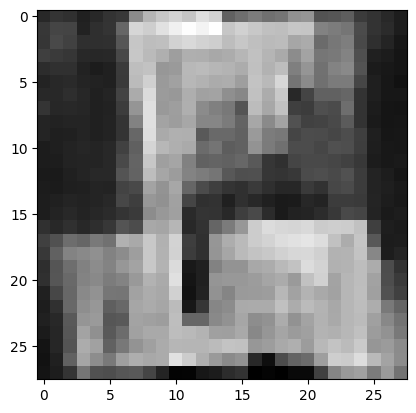

In [46]:
random_index = 3
plt.imshow(samples[-1][random_index].reshape(*(28,28), input_channels), cmap="gray")

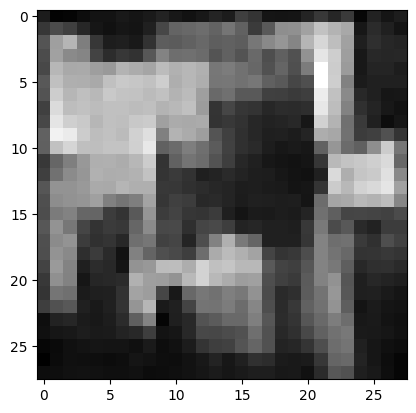

In [49]:
from utils import animate_diffusion
animate_diffusion(samples, timesteps, (*target_image_size, input_channels))